# Predicting Terminations
dataset info:

Title: Human Resources Data Set

Dataset Source: Kaggle

Dataset URL: https://www.kaggle.com/datasets/rhuebner/human-resources-data-set

Date Accessed: October 5, 2023

In [1]:
# Importing py libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [2]:
# Processing dataset into a py dataframe
df = pd.read_csv('HRDataset_v14.csv')

In [3]:
# Exploring the dataframe (EDA)
print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())

              Employee_Name  EmpID  MarriedID  MaritalStatusID  GenderID  \
0       Adinolfi, Wilson  K  10026          0                0         1   
1  Ait Sidi, Karthikeyan     10084          1                1         1   
2         Akinkuolie, Sarah  10196          1                1         0   
3              Alagbe,Trina  10088          1                1         0   
4          Anderson, Carol   10069          0                2         0   

   EmpStatusID  DeptID  PerfScoreID  FromDiversityJobFairID  Salary  ...  \
0            1       5            4                       0   62506  ...   
1            5       3            3                       0  104437  ...   
2            5       5            3                       0   64955  ...   
3            1       5            3                       0   64991  ...   
4            5       5            3                       0   50825  ...   

      ManagerName  ManagerID RecruitmentSource PerformanceScore  \
0  Michael Albert  

In [4]:
# Implementing a logistic regression model to predict terminations based on selected features

# Defining the target variable (Termd) and selected features of prediction
target = df['Termd']
features = df[['GenderID', 'DeptID', 'PerfScoreID', 'Salary', 'PositionID', 'EmpSatisfaction', 'SpecialProjectsCount', 'DaysLateLast30', 'Absences']]

# # Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# # Create and train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# # Make predictions on the test set
y_pred = model.predict(X_test)

# # Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))



Accuracy: 0.723404255319149
              precision    recall  f1-score   support

           0       0.74      0.92      0.82        66
           1       0.58      0.25      0.35        28

    accuracy                           0.72        94
   macro avg       0.66      0.59      0.59        94
weighted avg       0.70      0.72      0.68        94



In [5]:
# Predicting terminations using XGBoost model

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Handling missing values
df['ManagerID'].fillna(df['ManagerID'].mode()[0], inplace=True)
df.drop(['DateofTermination', 'EmploymentStatus', 'EmpStatusID', 'TermReason', 'LastPerformanceReview_Date', 'Employee_Name'], axis=1, inplace=True)

# Converting categorical data
for col in df.select_dtypes('object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Splitting dataset into train and test sets
X = df.drop('Termd', axis=1)
y = df['Termd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training and evaluating the XGBoost model
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

param = {
    'max_depth': 3,
    'eta': 0.3,
    'objective': 'binary:logistic'
}
num_round = 10

bst = xgb.train(param, dtrain, num_round)

# Make prediction
preds = bst.predict(dtest)
predictions = [round(value) for value in preds]

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 69.84%


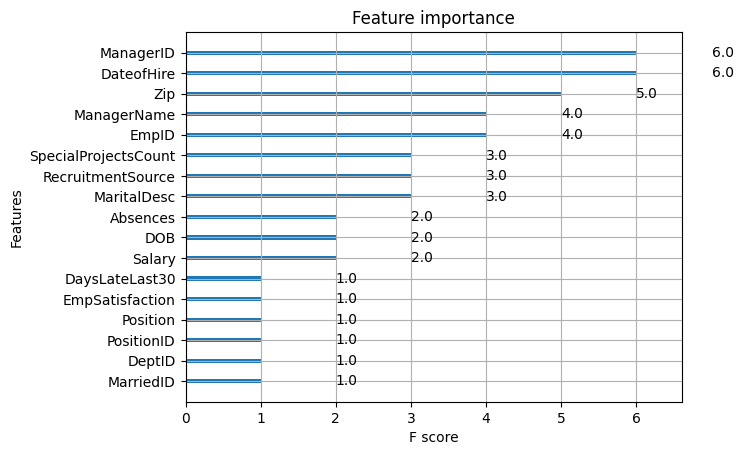

In [6]:
# Using the XGBoost model to determine who is most likely to terminate from our data set

# Visualizing the importance of selected features in making predictions
xgb.plot_importance(bst)
plt.show()

In [7]:
# Predicting the probability of termination for each employee
# This will give us an idea of "how likely" each employee is to terminate

# Getting probability predictions
probabilities = bst.predict(dtest)

# Adding probabilities to the test dataset
X_test['Probability_of_Termination'] = probabilities

# Merging probability of termination with our dataframe
df_termination_prob = pd.merge(df[['EmpID']], X_test[['Probability_of_Termination']], left_index=True, right_index=True)
print(df_termination_prob.head())

    EmpID  Probability_of_Termination
3   10088                    0.207092
5   10002                    0.164361
7   10062                    0.358975
9   10250                    0.187067
17  10055                    0.324704


In [8]:
# Creating a list for the top 20 employees at risk of termination
sorted_employees = X_test.sort_values(by='Probability_of_Termination', ascending=False)

# Taking the top 20 employees with the highest probability of termination for visualization
top_employees = sorted_employees.head(20)

print(top_employees)


     EmpID  MarriedID  MaritalStatusID  GenderID  DeptID  PerfScoreID  \
198  10215          0                0         1       5            3   
206  10078          1                1         0       5            3   
226  10262          0                2         0       5            3   
93   10093          0                0         1       5            3   
119  10059          0                2         0       5            3   
230  10140          1                1         1       6            3   
33   10107          0                0         0       5            3   
290  10144          0                2         1       5            3   
24   10267          0                0         0       5            3   
164  10134          1                1         1       1            3   
92   10049          1                1         0       5            3   
163  10087          0                0         0       5            3   
297  10293          0                0         0   